# 6. Optimizing, and sampling the kernel in low S/N sources
## I. Inferring PSD slope on idealized synthetic lightcurves

M. Gully-Santiago  
July 1-11, 2019
Kepler/K2 GO Office


In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

In [3]:
from nfft import nfft

Let's turn off `DEBUG` logging messages.

In [4]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# What does the real data look like in a PSD?

First let's get genuine data to simulate its properties as close as we can.

In [5]:
genuine_tpf = lk.search_targetpixelfile('EPIC 220182448', mission='K2', campaign=8).download()

You can use `genuine_tpf.interact()` to generate a *custom* aperture mask, **or** take the exact same mask as Everest.  Let's do the latter.  You can use `lc_Everest.dvs()` to see a data validation summary of the Everest data.

In [6]:
import everest

In [7]:
lc_Everest = everest.Everest(220182448, season=8, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220182448.


In [8]:
aperture_mask = lc_Everest.aperture.astype(np.bool)

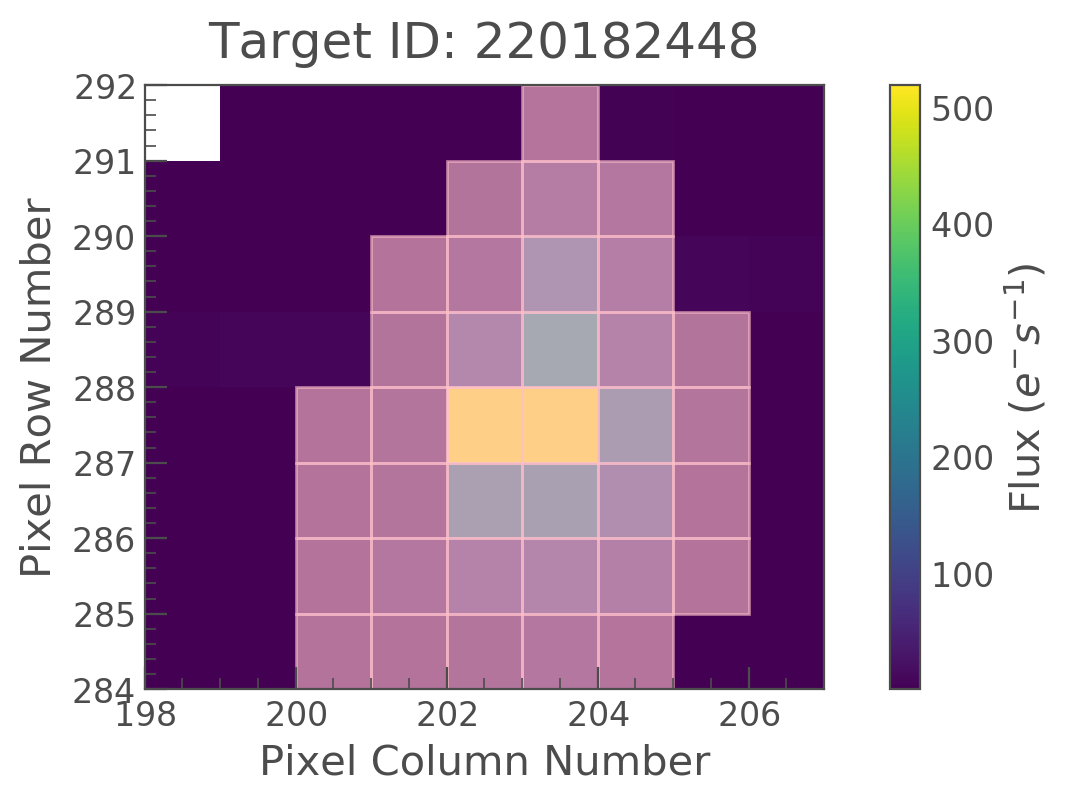

In [9]:
genuine_tpf.plot(aperture_mask=aperture_mask)

In [10]:
lc = genuine_tpf.to_lightcurve(aperture_mask=aperture_mask)

In [11]:
n_cad, = lc.time.shape
n_cad

3595

(3000, 3500)

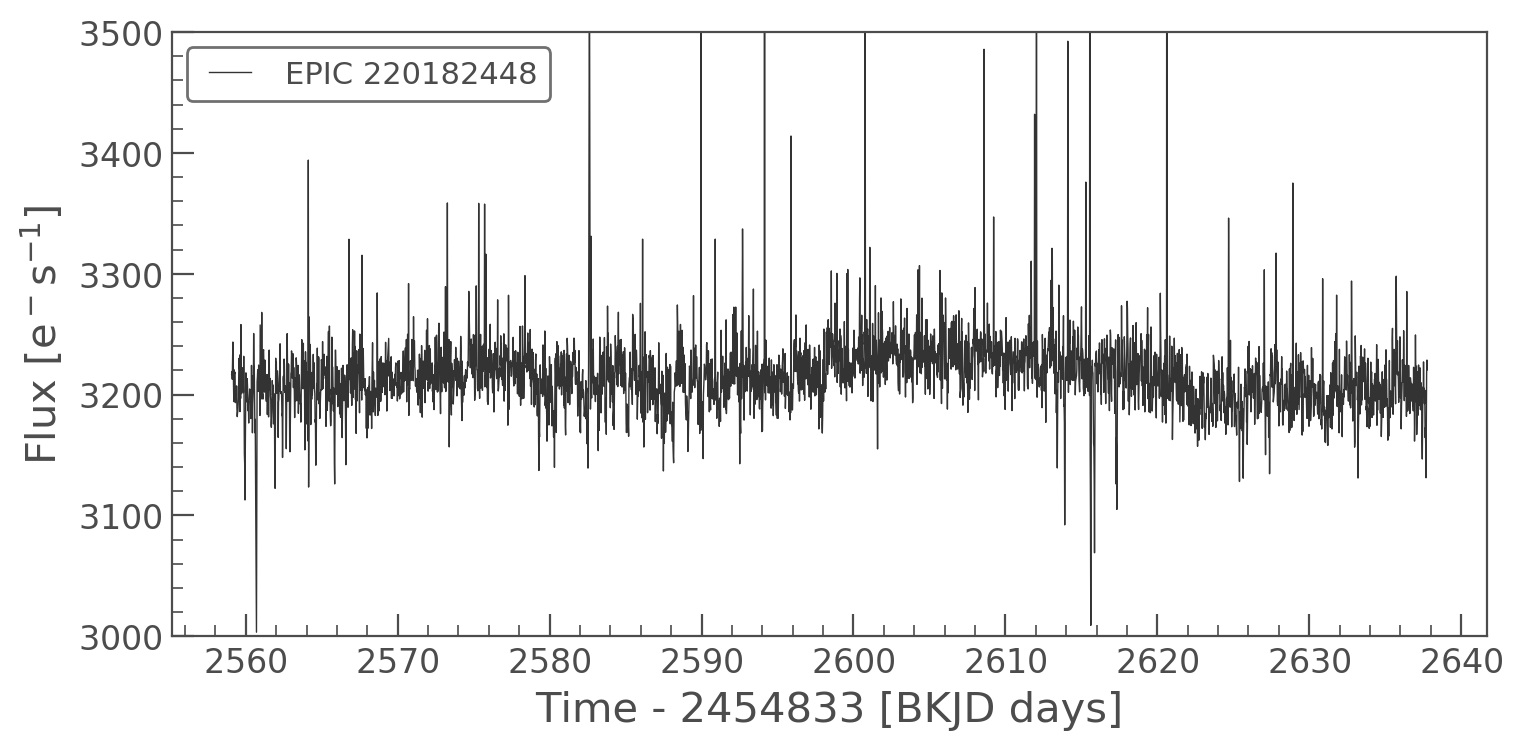

In [12]:
lc.plot(normalize=False)
plt.ylim(3000, 3500)

## Make the data-driven power spectrum.

In [13]:
import astropy.units as u

In [14]:
pg = lc.to_periodogram()#frequency=freq_array)

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


/Users/obsidian/GitHub/lightkurve/lightkurve/periodogram.py:697: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


In [15]:
from astropy.timeseries import LombScargle

f = np.fft.rfftfreq(80*48, 30.0*60)

# Compute the LS based power spectrum estimates
model = LombScargle(lc.time*86400,lc.flux)
power_ls = model.power(f[1:-1], method="fast", normalization="psd")

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= len(lc.time)

freq =  f[1:-1]

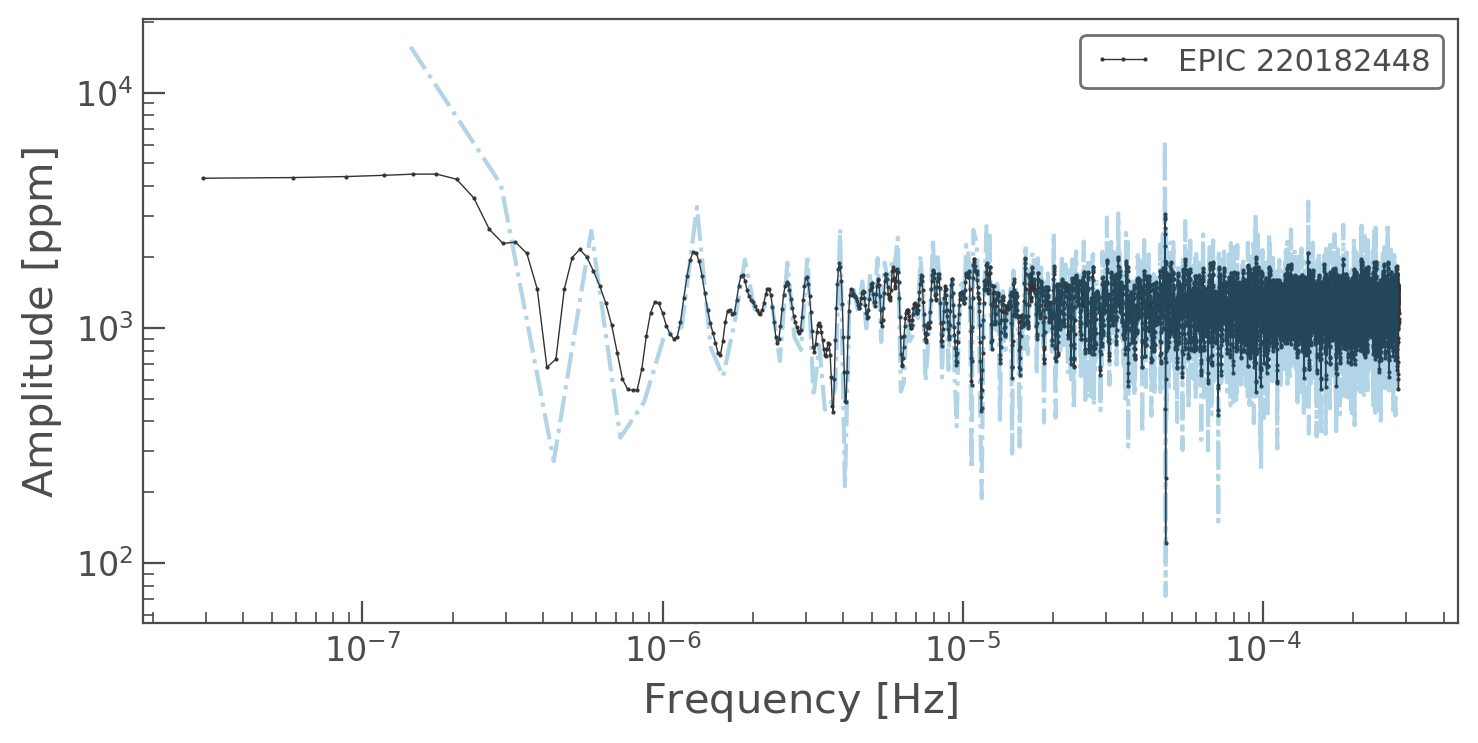

In [16]:
pg.plot(unit=u.Hz, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.plot(freq,power_ls*3e2, '-.', alpha=0.3)

In [17]:
t_char = (0.1*u.year).to(u.second)

In [18]:
c_val = 2.0*np.pi * 1/(t_char)

In [19]:
c_val.to(u.Hz) # units of Hertz

<Quantity 1.99102128e-06 Hz>

What about the value of $a$?  It should have units of $(\mathrm{dimensionless\; power}\cdot \mathrm{Hz})$, so it should be comparable to $c$ to achieve near-unity power.

In [20]:
a_val = c_val*3e7

In [21]:
a_val.to(u.Hz)

<Quantity 59.73063833 Hz>

We can use `celerite` to simulate the PSD.

In [22]:
from astropy.stats import LombScargle

import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_a (float): The log of the amplitude of the term.  
    - log_c (float): The log of the exponent of the term.

In [23]:
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)

In [24]:
kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) 

In [25]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)

In [26]:
# Simulate K datasets with N points
t = (lc.time*u.day).to(u.second).value

In [27]:
gp.compute(t)

In [28]:
np.random.seed(42)
NN = n_cad
KK = 500
y = gp.sample(size=KK)

In [29]:
y.shape

(500, 3595)

In [30]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

In [31]:
# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


In [32]:
# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

In [33]:
#  EQN 13 of DFM et al. celerite paper
analytic_power = np.sqrt(2/np.pi)*np.exp(true_loga)/np.exp(true_logc)*1/(1+(2.0*np.pi*f/np.exp(true_logc))**2) / (2*np.pi)

In [34]:
fake_omega = np.logspace(-6, -4, base=10)

In [35]:
fake_pow = fake_omega**(-2) / 1e9

The normalization scale diverges for [unknown reasons](https://github.com/dfm/celerite/issues/140) but the shape is always preserved.

In [37]:
simulated_signal = y[9, :]

# Make a scope-produced lightkurve

In [39]:
AGN_tpf = lk.KeplerTargetPixelFile('synthetic-k2-AGN.targ.fits')

0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


INFO  [lightkurve.utils.create_quality_mask()]: 0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


### Let's apply the SFF *and* PLD algorithms to compare

#### SFF (Vanderburg et al. 2015)

In [40]:
corrector = lk.SFFCorrector(lc)
cor_lc = corrector.correct(genuine_tpf.pos_corr2, genuine_tpf.pos_corr1, 
                             niters=4, windows=5, bins=7, restore_trend=True)

(0.98, 1.02)

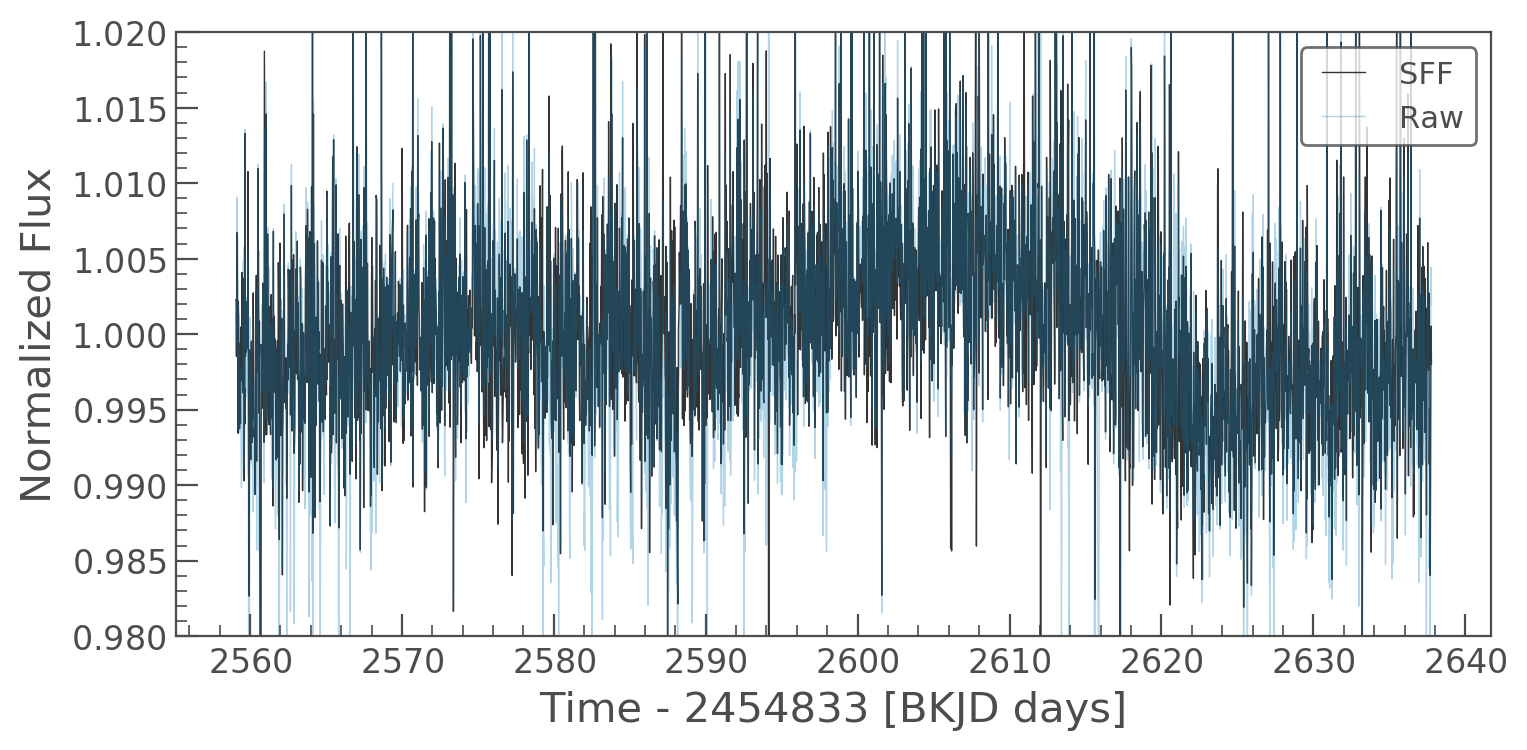

In [41]:
ax = cor_lc.plot(label='SFF')
lc.plot(ax=ax, label='Raw', alpha=0.3)
plt.ylim(0.98, 1.02)

Not much clear improvement from the detrending algorithm.

#### PLD (Luger et al. 2016)

In [42]:
corrector = lk.PLDCorrector(genuine_tpf)
cor_lc2 = corrector.correct(use_gp=True, aperture_mask=aperture_mask, pld_aperture_mask=aperture_mask)

In [43]:
mask = np.zeros(lc_Everest.flux.shape, dtype='bool')
mask[lc_Everest.badmask] = True

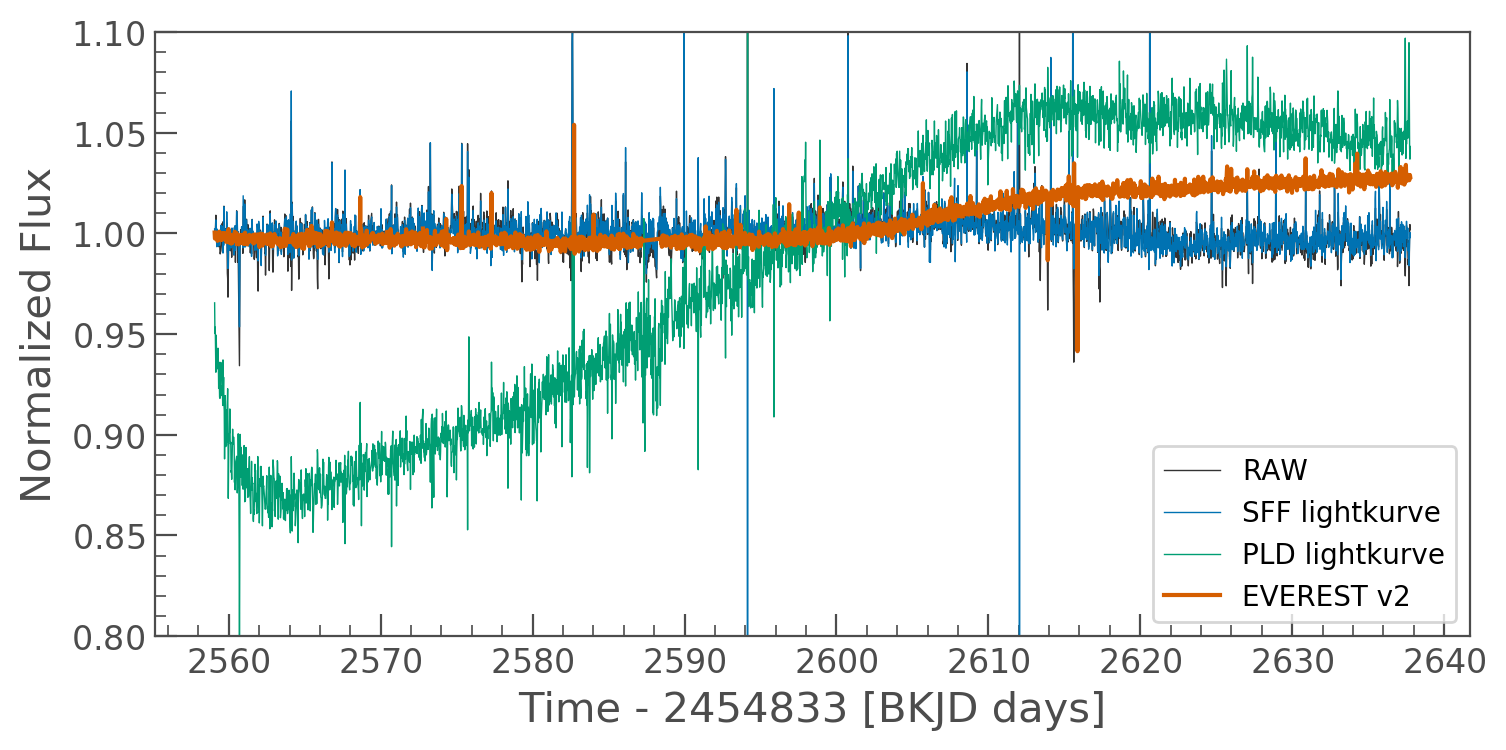

In [44]:
ax = lc.plot(label='RAW')
cor_lc.plot(label='SFF lightkurve', ax=ax)
cor_lc2.plot(label='PLD lightkurve', ax=ax)
plt.legend(loc='best')
plt.ylim(0.80, 1.10)

plt.plot(lc_Everest.time[~mask], lc_Everest.flux[~mask]/np.nanmedian(lc_Everest.flux), label='EVEREST v2')

plt.legend()
plt.savefig('AGN_K2_demo_data_lightcurve.png', dpi=300, bbox_inches='tight')

In [45]:
t = ((genuine_tpf.time-genuine_tpf.time[0])*u.day).to(u.second).value

In [46]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(np.fft.rfft(lc.flux)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft2 = fft.real / NN**2

In [47]:
# Compute the FFT based power spectrum estimates
fft = np.array(list(np.fft.rfft(cor_lc.flux)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft3 = fft.real / NN**2

In [48]:
# Compute the FFT based power spectrum estimates
fft = np.array(list(np.fft.rfft(cor_lc2.flux)))
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft4 = fft.real / NN**2

In [49]:
import seaborn as sns

In [50]:
sns.set_context('talk')

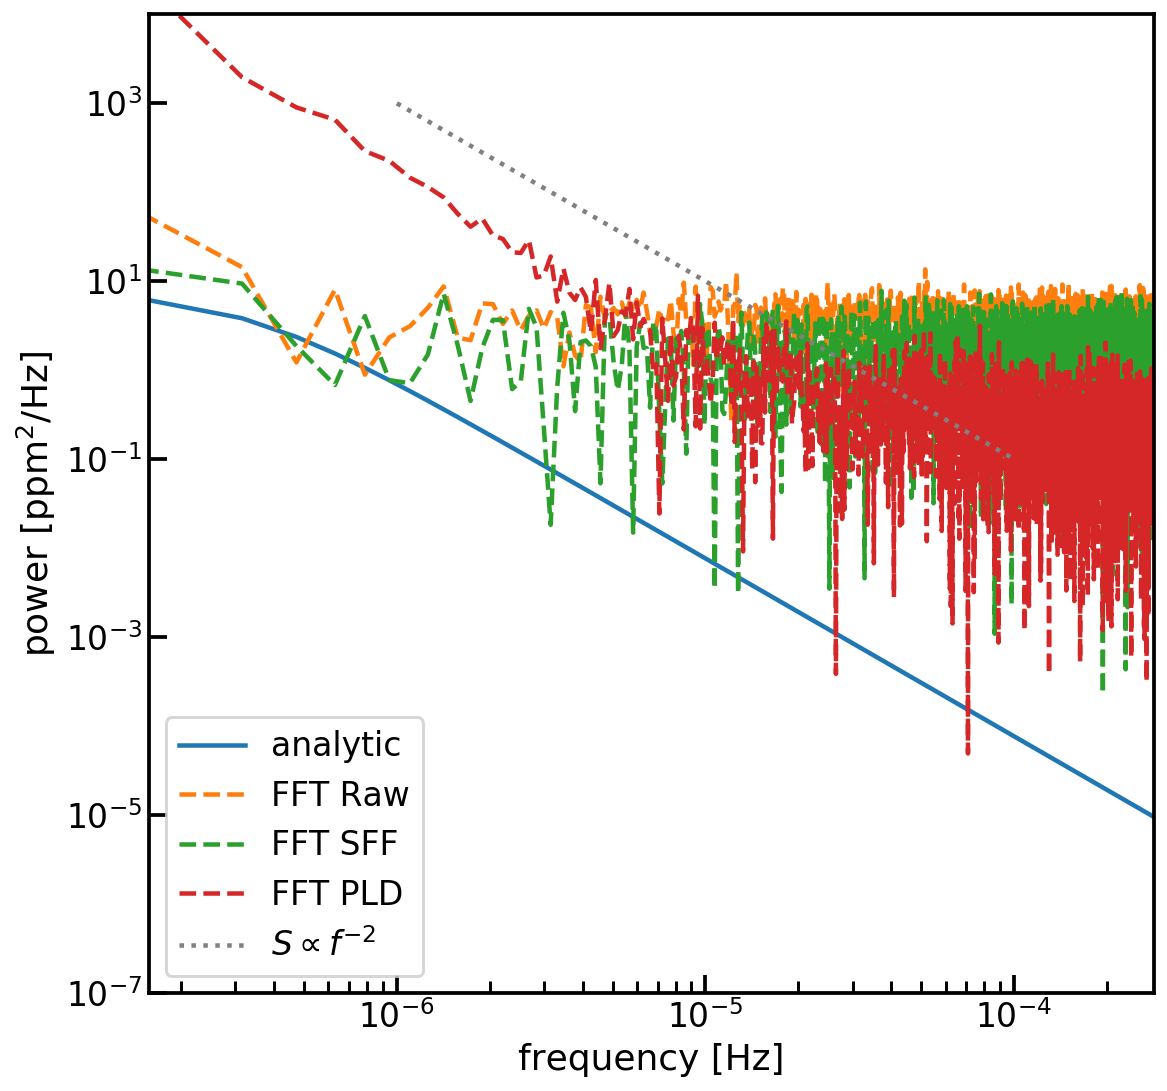

In [52]:
# Let's plot the estimates of the PSD
plt.figure(figsize=(9, 9))
plt.plot(f, analytic_power/5e5, label='analytic')
plt.plot(f, power_fft2, "--", label="FFT Raw")
plt.plot(f, power_fft3, "--", label="FFT SFF")
plt.plot(f, power_fft4, "--", label="FFT PLD")
#plt.plot(f, power_fft5, "--", label="FFT True")
#plt.plot(f[1:-1], np.median(power_ls, axis=0), "-", label="LS ideal")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, ':', color='gray', label='$S \propto f^{-2}$')
plt.ylim(1e-7, 1e4)
plt.legend()

plt.savefig('AGN_K2_PSD_data_detrend.png', dpi=300, bbox_inches='tight')